In [ ]:
%load_ext jupyter_black

# Download the data
_This notebook is mostly taken from https://github.com/rasbt/machine-learning-book/tree/main, chapter 15._

We are going to download from the Project Gutenberg website (https://www.gutenberg.org/).

In [23]:
import urllib.request


path_to_save_the_file = "Data/text"
urllib.request.urlretrieve(
    "https://www.gutenberg.org/cache/epub/5711/pg5711.txt", path_to_save_the_file
)

('Data/text', <http.client.HTTPMessage at 0x1fec47ef850>)

The whole file can be read and store in the _text_ variable using the following commands

In [3]:
with open(path_to_save_the_file, "r", encoding="utf8") as the_file:
    text = the_file.read()
print(text[0:500] + "...")

﻿The Project Gutenberg eBook of Germinal
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Ger...


We can remove some parts of the text not relevant to our analysis (beginning and ending):

In [4]:
start_index = text.find("Première Partie")
end_index = text.find("*** END OF THE PROJECT GUTENBERG EBOOK GERMINAL ***")
text = text[start_index:end_index]
print(f"Size of the book (as the number of characters): {len(text)}")

Size of the book (as the number of characters): 1011351


# Prepare the tokenizer
For this labwork, we are going to do simple things: a token will be a character from the book. So the first steps to prepare the data is to:
1. Get the set of unique characters of the string _text_
2. Create a function converting each caracters into an unique value
3. For later inference, create the inverse function

This can be done using the ScikitLearn _LabelEncoder_ function. 

Hint: to convert each caracter of a long string to an numpy array of caracters:

In [5]:
import numpy as np

text_array = np.array(list(text))

In [6]:

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(text_array)
text_encoded=le.transform(text_array)
print(text_encoded)

[35 63 50 ...  1  1  1]


In [7]:
print(f"{text[:8]} == Encoding ==> {text_encoded[:8]}")
print(
    f"{text_encoded[23:37]} == Decoding ==> {le.inverse_transform(text_encoded[23:37])}"
)

Première == Encoding ==> [35 63 50 58 54 79 63 50]
[23 46 59 64  1 57 46  1 61 57 46 54 59 50] == Decoding ==> ['D' 'a' 'n' 's' ' ' 'l' 'a' ' ' 'p' 'l' 'a' 'i' 'n' 'e']


# Torch Data Loader
For this learning problem, we want to learn the most probable caracters given a sequence of caracters of fixed lenght. To build the data set, we need to extract such sequences. The size of the sequence is a very important hyperparameter: too small, we would not capture only local dependences, and too big, it will results in a too complicated problem. It will be set to 40 here. So we want to predict the 41th caracters.

In [8]:
seq_length = 40
chunk_size = seq_length + 1
chunks = np.array(
    [text_encoded[i : i + chunk_size] for i in range(len(text_encoded) - seq_length)]
)

The torch dataset should output the first 40 caracters of the chunck as the input variable and the last 40 caracter as the output variable. To compute the BTT we need to feed the model with a caracter and its immediate next one of the sequence until predicting the 41th ones.

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Tuple


class TextDataset(Dataset):
    def __init__(self, chunks):
        self.chunks = chunks

    def __len__(self):
        return len(self.chunks)

    def __getitem__(self, idx):
        chunk = self.chunks[idx]
        return chunk[:-1].long(), chunk[1:].long()

And now we are done with the Data loader

In [10]:
seq_dataset = TextDataset(torch.tensor(chunks))
torch.manual_seed(1)
batch_size = 512
seq_data_loader = DataLoader(
    seq_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

In [11]:
(seq, target) = next(iter(seq_dataset))
print("Sequence:\n", "".join(le.inverse_transform(seq)))
print("Target:\n", "".join(le.inverse_transform(target)))

Sequence:
 Première Partie



I


Dans la plaine ra
Target:
 remière Partie



I


Dans la plaine ras


# RNN Model
We miss a last step to build the model: the tokens are integer number that corresponds to unique words. We need to convert this values into an input feature vector. One hot encoding can be used as for class label. However, it will result in very sparse feature and the associated feature space will be mostly empty. Something which is difficult to work with.
A more appropriate approach is to map each token into a vector space of fixed size. For instance, $\{1, 2, 3\}$ could be mapped to $[(0,1), (1,0), (1,1)]$ in $\mathbb{R}^2$. This is called _embedding_ and as usuall with deep learning, it can be learned from the data once the embedding dimension is selected. A rule of dumb is that the embedding dimensions to much smaller than the number of possible outcomes for the token values. Some work mention a square root relation. Should be tested in practice.

In [16]:
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, token_size: int, embed_dim: int, rnn_hidden_size: int):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(token_size, embed_dim)

        self.rnn_hidden_size = rnn_hidden_size
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, batch_first=True)
        self.fc = nn.Linear(rnn_hidden_size, token_size)

    def forward(
        self, X: torch.Tensor, hidden: torch.Tensor, cell: torch.Tensor
    ) -> torch.Tensor:
        # PASS
        # RNN is waiting for [n_batch, n_layer, input_size = embded_dim]
        # We need to add one dimension for the number of lstm layers - here 1
        out = self.embedding(X).unsqueeze(1)
        out, (hidden, cell) = self.rnn(out, (hidden, cell))
        # out for rnn/lstm  is of size [n_batch, n_layers, rnn_hidden_size] with n_layers 1
        # Here we "remove" the dimension corresponding to the layers == view(n_batch, token_size)
        out = self.fc(out).reshape(out.size(0), -1)
        print(out.shape)
        return out, hidden, cell

    def init_hidden_layers(
        self, batch_size, device="cpu"
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # LSTM waits for input of size (n_layers, n_batch, rnn_hidden_size)
        hidden = torch.zeros(1, batch_size, self.rnn_hidden_size).to(device)
        cell = torch.zeros(1, batch_size, self.rnn_hidden_size).to(device)
        return hidden, cell

We can defined the learning step. For this labwork, we don't define a test and validation sets.

In [22]:
token_size = le.classes_.size
embed_dim = 32
rnn_hidden_size = 512
torch.manual_seed(1)
model = RNN(token_size, embed_dim, rnn_hidden_size)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Vérifier si CUDA (GPU) est disponible
if torch.cuda.is_available():
    # Nombre de GPU disponibles
    num_devices = torch.cuda.device_count()
    print(f"Nombre de GPU disponibles : {num_devices}")

    # Liste des noms de chaque GPU
    for i in range(num_devices):
        device_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {device_name}")
else:
    print("CUDA n'est pas disponible. Utilisation du CPU.")

print(model.init_hidden_layers(batch_size))

Nombre de GPU disponibles : 1
GPU 0: NVIDIA GeForce RTX 3050 Laptop GPU
(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]))


In [18]:
# Set device - RNN is training is very long -> A GPU would be very welcome
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

for epoch in range(1):
    accu = 0.0
    for seq_batch, target_batch in seq_data_loader:
        seq_batch, target_batch = seq_batch.to(device), target_batch.to(device)
        loss = 0.0
        optimizer.zero_grad()
        h , c = model.init_hidden_layers(512)
        h , c=h.to(device) , c.to(device)
        for i in range(seq_length):
            y_pred,h,c=model(seq_batch[:,i],h,c)  
            loss+=loss_fn(y_pred,target_batch[:,i])
            

        loss.backward()
        optimizer.step()
        accu += loss.item()
    print(f"Epoch {epoch}: {accu/len(seq_data_loader)/seq_length}")

torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size

torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size

torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size

torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size

torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size

torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size

torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size([512, 88])
torch.Size

KeyboardInterrupt: 

Once the model is learned, it possible to get the most probable character given the (sequence of) previous one, as for classification we only need to get the caracter with the maximum output. However, it is possible to take into account the most probables caracters by looking at the multinomial distribution, with parameters provided by the model outputs, and generate caracters according to the distribution. Lets consider the multinomial distribution with parameters $[0.45,0.40,0.15]$: the most probable class is the first one. But using pytorch distribution facilities, it is possible to sample class such as:

In [30]:
from torch.distributions.categorical import Categorical

scale = 1
dist = Categorical(probs=torch.tensor([0.45, 0.40, 0.15]) ** scale)
dist.sample([20])

tensor([1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 2, 1, 0, 1, 2, 2, 1, 1, 0])

The _scale_ parameter is used to control the degree of randomness for the sampling of randomness. Higher value of scale will results in more "one-hot" like sample vector. For two almost equally probable classes, a higher value of _scale_ will favor the most probable class, while a lower value of scale will make both (or all) classes equally probable during the sampling.

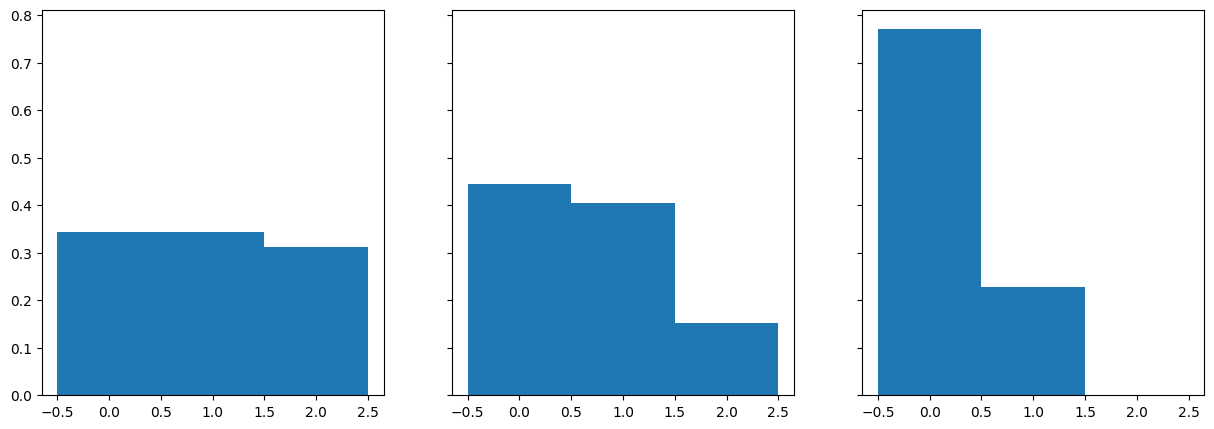

In [31]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, sharex=True, figsize=(15, 5))
for scale, ax in zip([0.1, 1, 10], axs):
    dist = Categorical(probs=torch.tensor([0.45, 0.40, 0.15]) ** scale)
    samples = dist.sample([10000])
    ax.hist(samples, bins=[-0.5, 0.5, 1.5, 2.5], density=True)

We can now define the sampling strategy to generate a text, given some sentence. We will use the scale parameter to control the amount of randomness.

In [45]:


def model_sampling(
    model: RNN,
    le: LabelEncoder,
    starting_str: str,
    generated_text_len: int = 500,
    scale_factor: float = 1.0,
    random_state=0,
):
    torch.manual_seed(random_state)
    generated_str = starting_str
    # Encode input
    encoded_input = torch.tensor(le.transform(list(starting_str))).reshape(1, -1)

    model.eval()
    with torch.no_grad():
        hidden, cell = model.init_hidden_layers(1)
        # Iterate over the input to initialize h and c
        for c in range(len(starting_str)):
            _, hidden, cell = model(encoded_input[:, c].view(1), hidden, cell)

        # Iterate until the generated text has the correct size
        last_char = encoded_input[:, -1]
        for i in range(generated_text_len):
            logits, hidden, cell = model(last_char.view(1), hidden, cell)
            logits = scale_factor * torch.squeeze(logits, 0)
            m = Categorical(logits=logits)
            last_char = m.sample()
            generated_str += le.classes_[last_char.item()]

    return generated_str

TypeError: 'module' object is not callable

In [53]:
model =RNN(token_size=88, embed_dim=64, rnn_hidden_size=512)

model.load_state_dict(torch.load("RNN_Models/rnn_parameters_64_512.pt"))

starting_str = "les ouvriers pose"
print(model_sampling(model, le, starting_str, scale_factor=100))

les ouvriers poses, de l'embranche, il serait au premier rang,
Maheu se sentait blêmir, lui aussi, très loin, au
premier étage, où la trompe d'épaules, elle avait lancé ça
d'un air misère de la Direction.  Sa fraîcre d'une énergie
qui s'emportait davantage, le malaise de ces grosses voix
d'homme.



II


Dès la veille, dans une place de cochon de leurs
galeries, la route de Joiselle, à gaieté trop lente, mais il y a les pas les câbles! Qu'agitant en silence.

--Nous autres, ça va jusqu'à présent, abandon ne dema
